Many thanks for the book [The Hundred-Page Machine Learning Book](http://themlbook.com/) by [Andriy Burkov](https://www.linkedin.com/in/andriyburkov/), so please [check this out](http://themlbook.com/wiki/doku.php?id=start)

## 0. Imports

In [1]:
# !pip install -U scikit-learn==1.2.2

In [2]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\kosty\anaconda3\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bayesian-optimization, dtreeviz, finrl, imbalanced-learn, lightgbm, pyfolio, pynndescent, scikit-optimize, seqeval, umap-learn, yellowbrick


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from prediction_strength import get_prediction_strength
from tqdm.notebook import tqdm
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,5)

## 1. Read data

In [4]:
df = pd.read_csv(r"data/WQ-R.csv",sep=";")

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print(f"N rows - {df.shape[0]}\nN cols - {df.shape[1]}")

N rows - 1599
N cols - 12


In [7]:
y = df["quality"].astype(int)
X = df.drop(["quality"], axis = 1)

In [8]:
(y.value_counts().sort_index()/y.shape[0]*100).round(2)

3     0.63
4     3.31
5    42.59
6    39.90
7    12.45
8     1.13
Name: quality, dtype: float64

There are 3 big clusters based on quality's values (4,5,6) and others (3,4,8) values are relatively poor presented

In [9]:
labels = X.columns
print(f"Features:\n{X.columns.to_list()}")

Features:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## 2. KMeans
Dividing the data set into clusters with a random initialization and outputting the coordinates of the centers of the clusters.
The optimal number of clusters can be determined based on the initial data set in three different ways:
    1) elbow method;
    2) average silhouette method;
    3) prediction strength method (see section 9.2.3 Determining the Number of Clusters of the book Andriy Burkov. The Hundred-Page Machine Learning Book).
Compare the obtained results and explain which method gave the best result and why (in your opinion).

I have found [this article](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891) extremely useful.
The article stands out with its easy readability and its effective simplification of complex ideas using relevant examples.
Its clear descriptions and the inclusion of useful functions for cluster analysis make it a highly valuable resource
<img src="img/Silhouette Method.png">

Here is [another article](https://uc-r.github.io/kmeans_clustering), which is great source for studying theory enough to get intuition behind K-means cluster analysis.
Especially, Determining Optimal Clusters topic is written good.

## 2.1) Elbow method

**KElbowVisualizer**
By default, the scoring parameter metric is set to distortion,
which computes the sum of squared distances from each point to its assigned center.

However, two other metrics can also be used with the KElbowVisualizer – silhouette and calinski_harabasz.
The silhouette score calculates the mean Silhouette Coefficient of all samples,
while the calinski_harabasz score computes the ratio of dispersion between and within clusters.
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html?highlight=metric

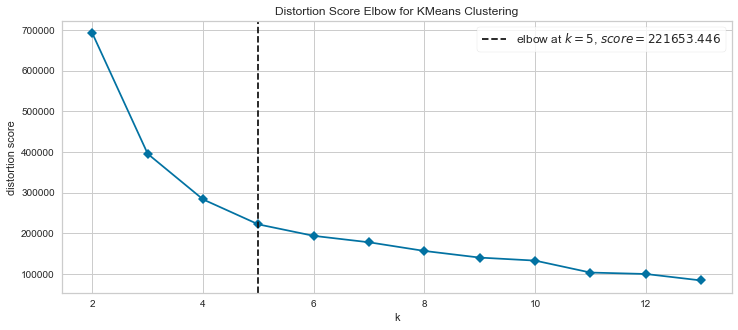

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Instantiate the clustering model and visualizer
model = KMeans(init='random', random_state=42)
visualizer = KElbowVisualizer(
    model, k=(2,14), metric='distortion', timings=False
)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

Plot Distortion Score Elbow for KMeans Clustering using fitted KMeans.inertia_ attribute.

Center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.424258  0.519334  0.266539  2.394275  0.085446  12.371925  30.344360  0.996677  3.315522  0.656531  10.540218
1  8.025952  0.551643  0.283429  2.944524  0.093138  25.708333  91.728571  0.996943  3.298738  0.662690  10.093889

Center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.286996  0.520504  0.272436  2.497070  0.091310  21.570513   54.888278  0.996856  3.320201  0.677106  10.376801
1  7.887552  0.572365  0.275643  3.232365  0.088398  26.151452  108.506224  0.996935  3.289627  0.652033  10.008921
2  8.469828  0.519520  0.268608  2.361022  0.084606   8.995074   22.392857  0.996618  3.311379  0.647217  10.576929

Center`s coordinates for n_clusters 4:
         0         1         2         3         4          5           

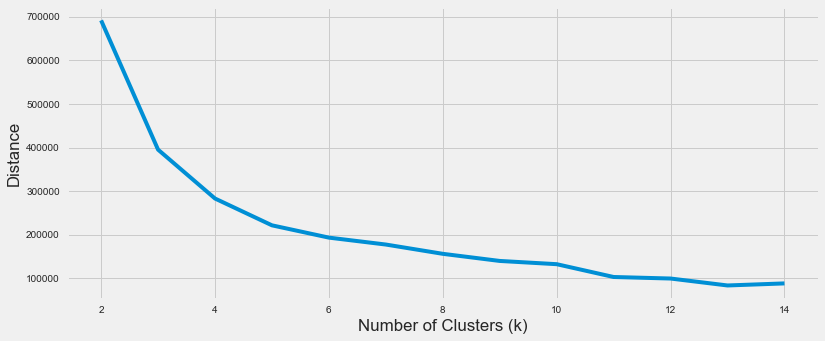

In [11]:
avg_distance = []
range_n_clusters = range(2, 15)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='random', random_state=42).fit(X)
    print(f'Center`s coordinates for n_clusters {n_clusters}:\n{pd.DataFrame(clusterer.cluster_centers_).to_string()}\n')
    avg_distance.append(clusterer.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

In the above plot, there is a sharp fall of average distance at k=3, 4 and 5. Here comes a confusion to pick the best value of k.

## 2.2) Average silhouette method

Center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.424258  0.519334  0.266539  2.394275  0.085446  12.371925  30.344360  0.996677  3.315522  0.656531  10.540218
1  8.025952  0.551643  0.283429  2.944524  0.093138  25.708333  91.728571  0.996943  3.298738  0.662690  10.093889

Center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.286996  0.520504  0.272436  2.497070  0.091310  21.570513   54.888278  0.996856  3.320201  0.677106  10.376801
1  7.887552  0.572365  0.275643  3.232365  0.088398  26.151452  108.506224  0.996935  3.289627  0.652033  10.008921
2  8.469828  0.519520  0.268608  2.361022  0.084606   8.995074   22.392857  0.996618  3.311379  0.647217  10.576929

Center`s coordinates for n_clusters 4:
         0         1         2         3         4          5           

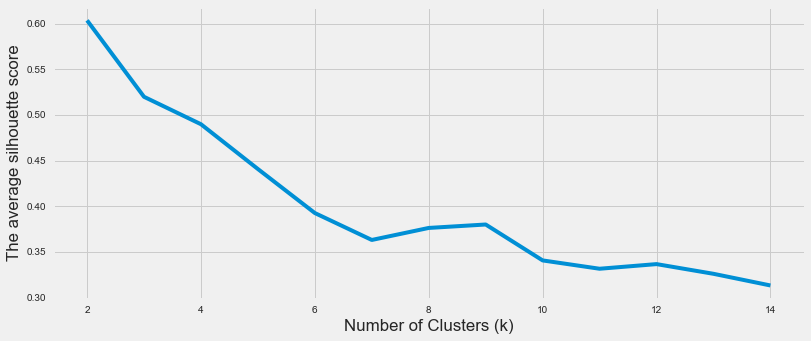

In [12]:
silhouette_avg_n_clusters = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='random', random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    print(f'Center`s coordinates for n_clusters {n_clusters}:\n{pd.DataFrame(clusterer.cluster_centers_).to_string()}\n')

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("The average silhouette score")
plt.show()

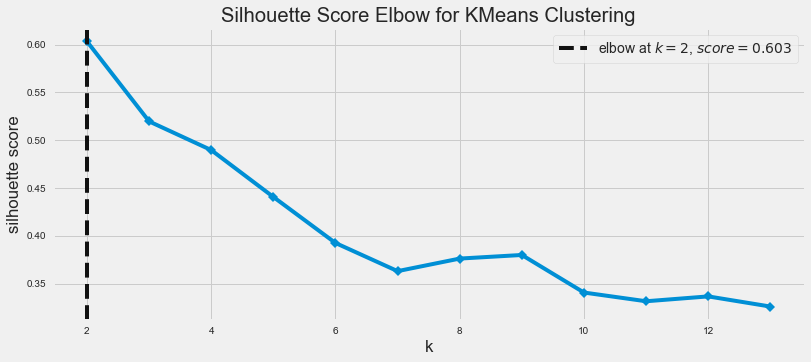

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
model = KMeans(init='random', random_state=42)
visualizer = KElbowVisualizer(
    model, k=(2,14), metric='silhouette', timings=False
)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

The silhouette plot shows that the n_cluster value of more than 6 is a bad pick.
So, let`s investigate deeper n_cluster values 2-6 by plotting the silhouette scores for each sample in cluster.

For n_clusters = 2 The average silhouette_score is : 0.6034220347331241
For n_clusters = 3 The average silhouette_score is : 0.5197446557038226
For n_clusters = 4 The average silhouette_score is : 0.48971967046233833
For n_clusters = 5 The average silhouette_score is : 0.44067114071766816
For n_clusters = 6 The average silhouette_score is : 0.392490880418337


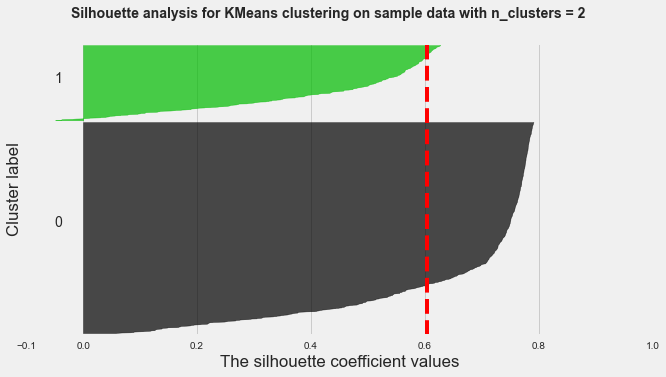

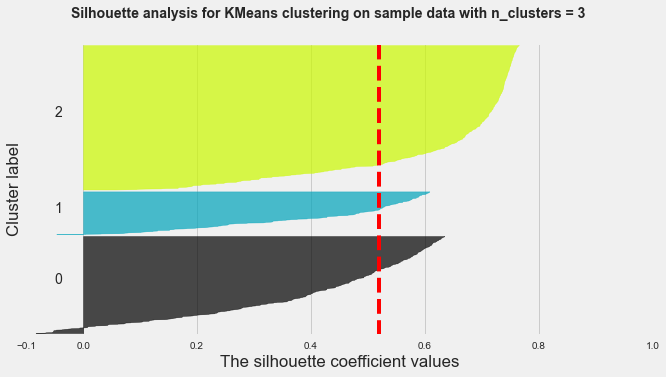

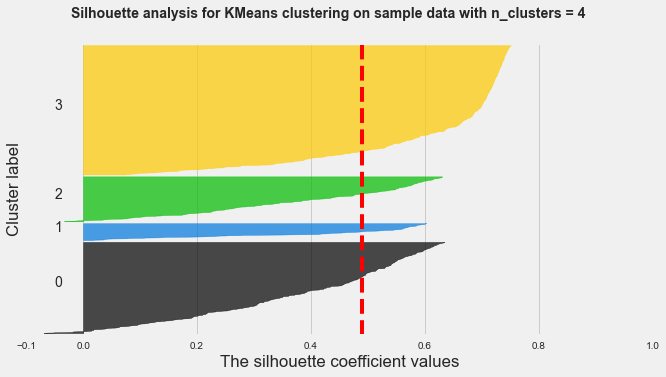

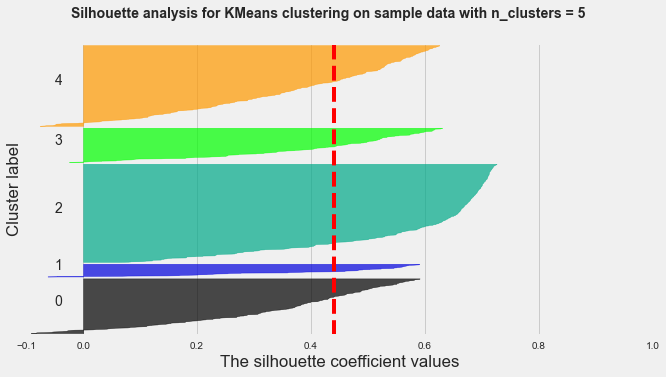

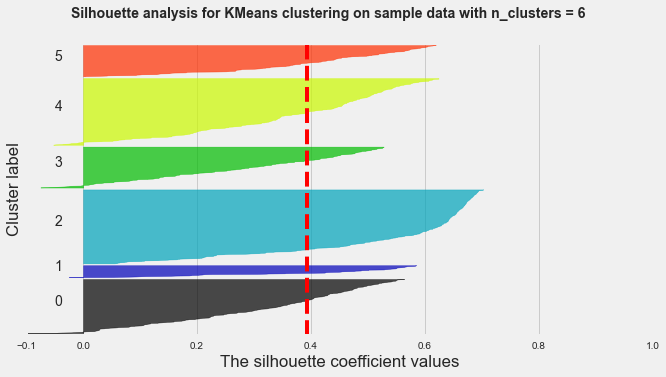

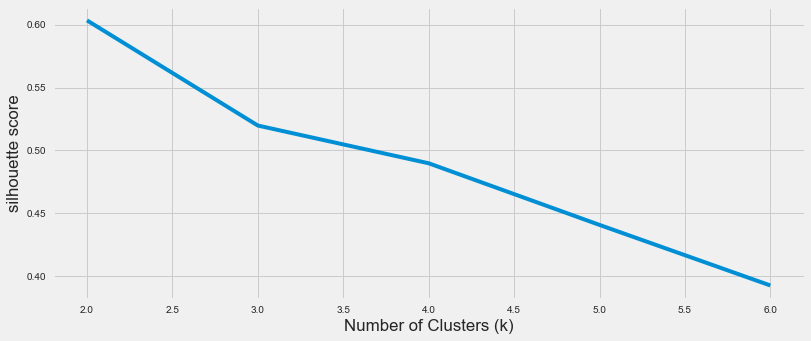

In [14]:
silhouette_avg_n_clusters = []
range_n_clusters = range(2, 7)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='random', random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

The silhouette plots show that all the points in the clusters are below-average silhouette scores.
I prefer to choose between 3 and 4, considering the points in the cluster with cluster_label=1,2 are both higher than 0.6.
Talking in machine learning terms, n_clusters=2 is under-fitting and n_clusters=5 is over-fitting.

## 2.3) Prediction strength method

I have found [this article](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891) extremely useful.
Especially, Prediction Strength topic with provided python f-ns for calculation.
<img src="img/Prediction Strength.png">

In [15]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, shuffle=True, stratify=y, random_state=42)

  0%|          | 0/8 [00:00<?, ?it/s]

Train, center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.096034  0.549433  0.296459  2.956091  0.095255  25.575071  91.254958  0.996983  3.290057  0.671246  10.085930
1  8.386717  0.519930  0.265270  2.386339  0.086525  12.526458  30.517279  0.996641  3.315648  0.660788  10.553492

Test, center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.546899  0.515930  0.270620  2.421705  0.081384  12.135659  30.306202  0.996801  3.316085  0.641434  10.487145
1  7.645161  0.572097  0.212581  2.927419  0.082500  26.217742  96.951613  0.996754  3.342581  0.613710  10.125806



Train, center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  7.961026  0.570821  0.293795  3.256410  0.089533  

[Text(0.5, 1.0, 'Determining the optimal number of clusters'),
 Text(0.5, 0, 'number of clusters'),
 Text(0, 0.5, 'prediction strength')]

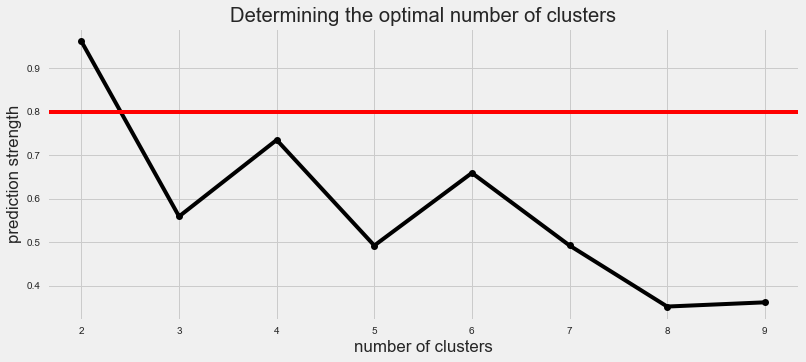

In [16]:
# running the clustering
strengths = []
range_n_clusters = range(2, 10)

for k in tqdm(range_n_clusters):
    model_train = KMeans(n_clusters=k, init='random', random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, init='random', random_state=42).fit(X_test)

    print(f'Train, center`s coordinates for n_clusters {k}:\n{pd.DataFrame(model_train.cluster_centers_).to_string()}\n')
    print(f'Test, center`s coordinates for n_clusters {k}:\n{pd.DataFrame(model_test.cluster_centers_).to_string()}\n\n\n')

    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(range_n_clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

We can see that the recommended cluster size is 2.
Considering between 3 and 4, we should go for 4.

## Summary
We got optimal n_clucters value in range 3-6, using the elbow method.
Then, the average silhouette method showed the best metric at n_clucters=2, but we chose 3-4 range.
The last method showed that the only n_clucters=2 over-performed prediction strength threshold 0.8.
The second-best result was devoted to n_clucters=4.

# 3. KMeans++
Run multiple times for the previously selected number of clusters k-means clustering, using k-means++ method for initial initialization.
Choose the best clustering option using chosen quantitative criterion.

To get familiar with K-means++, I found useful this article [k-means++: The Advantages of Careful Seeding](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)

## 3.1) Elbow method

  0%|          | 0/13 [00:00<?, ?it/s]

Center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.424258  0.519334  0.266539  2.394275  0.085446  12.371925  30.344360  0.996677  3.315522  0.656531  10.540218
1  8.025952  0.551643  0.283429  2.944524  0.093138  25.708333  91.728571  0.996943  3.298738  0.662690  10.093889

Center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.482381  0.519446  0.270619  2.371012  0.084494   9.183333   22.955952  0.996628  3.310333  0.648333  10.589246
1  7.887552  0.572365  0.275643  3.232365  0.088398  26.151452  108.506224  0.996935  3.289627  0.652033  10.008921
2  8.256757  0.520676  0.269382  2.488224  0.091853  21.944981   55.731660  0.996851  3.322375  0.676911  10.346010

Center`s coordinates for n_clusters 4:
         0         1         2         3         4          5           

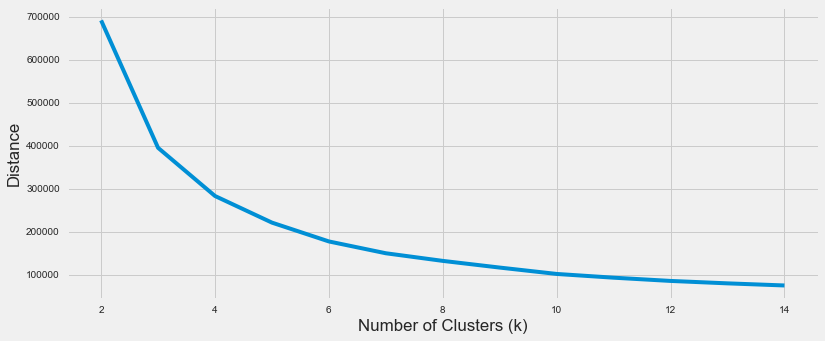

In [17]:
avg_distance = []
range_n_clusters = range(2, 15)
for n_clusters in tqdm(range_n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, random_state=42).fit(X)
    print(f'Center`s coordinates for n_clusters {n_clusters}:\n{pd.DataFrame(clusterer.cluster_centers_).to_string()}\n')

    avg_distance.append(clusterer.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

Running 100 times the k-means algorithm with different centroid seeds definitely made difference.
The curve became smoother. It is very interesting, so let`s take a look at the sklearn documentation:

*"The final results is the best output of n_init consecutive runs in terms of inertia."*

There are relatively a sharp falls of average distance at k=3 and 4.

## 3.2) Average silhouette method

Center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.424258  0.519334  0.266539  2.394275  0.085446  12.371925  30.344360  0.996677  3.315522  0.656531  10.540218
1  8.025952  0.551643  0.283429  2.944524  0.093138  25.708333  91.728571  0.996943  3.298738  0.662690  10.093889

Center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.482381  0.519446  0.270619  2.371012  0.084494   9.183333   22.955952  0.996628  3.310333  0.648333  10.589246
1  7.887552  0.572365  0.275643  3.232365  0.088398  26.151452  108.506224  0.996935  3.289627  0.652033  10.008921
2  8.256757  0.520676  0.269382  2.488224  0.091853  21.944981   55.731660  0.996851  3.322375  0.676911  10.346010

Center`s coordinates for n_clusters 4:
         0         1         2         3         4          5           

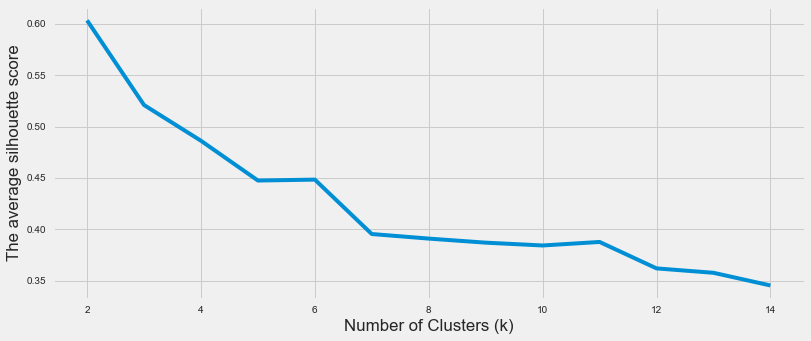

In [18]:
silhouette_avg_n_clusters = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    print(f'Center`s coordinates for n_clusters {n_clusters}:\n{pd.DataFrame(clusterer.cluster_centers_).to_string()}\n')

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("The average silhouette score")
plt.show()

The silhouette plot shows that the n_cluster value of more than 5 is a bad pick,
as the average silhouette score is the same or lower than at n_cluster = 5.
So, let`s investigate deeper n_cluster values 2-5 by plotting the silhouette scores for each sample in cluster.

For n_clusters = 2 The average silhouette_score is : 0.6034220347331241
For n_clusters = 3 The average silhouette_score is : 0.5209776312111326
For n_clusters = 4 The average silhouette_score is : 0.48617291416050135
For n_clusters = 5 The average silhouette_score is : 0.4474368189327113


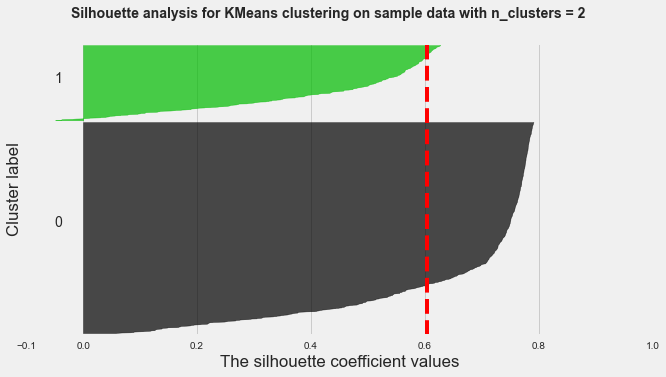

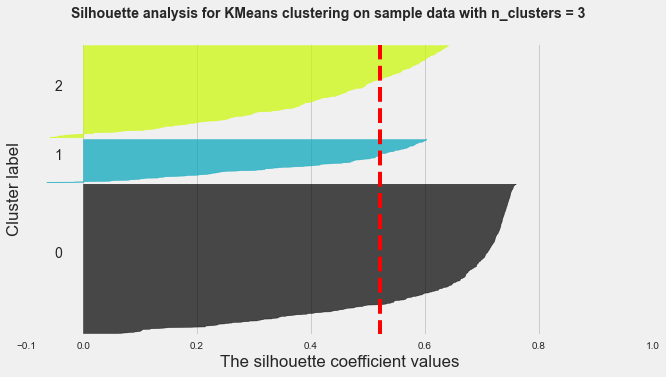

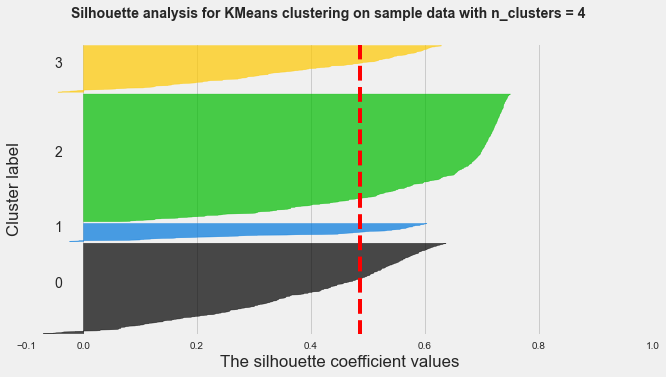

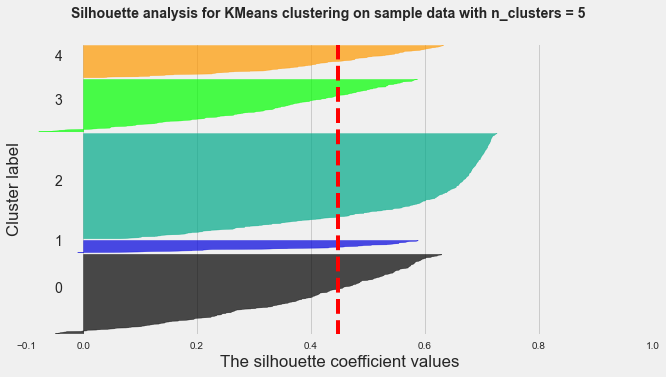

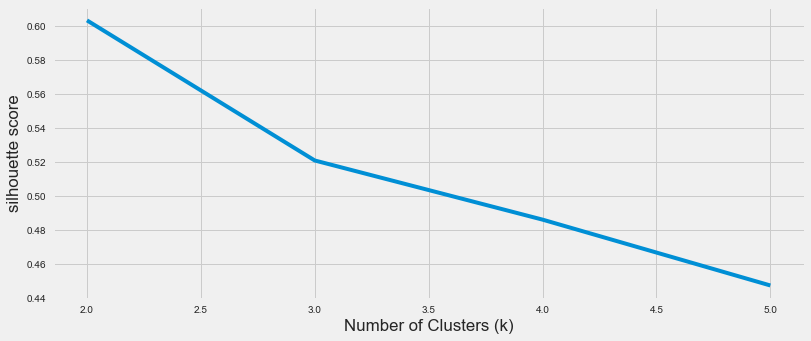

In [19]:
silhouette_avg_n_clusters = []
range_n_clusters = range(2, 6)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

Let`s compare results of init mode 'random' and 'kmeans++':
- For n_clusters = 2: The average silhouette_score is : 0.6034 vs 0.6034
- For n_clusters = 3 The average silhouette_score is : 0.5197 vs 0.5209
- For n_clusters = 4 The average silhouette_score is : 0.4897 vs 0.4861
- For n_clusters = 5 The average silhouette_score is : 0.4406 vs 0.4474

We definitely can find the difference.
At n_clusters=5, we can find 2nd cluster had more than 0.6 silhouette_score at init mode 'random'.
Which seems to be misleading, because we have got silhouette_score value less than 0.6  using init mode 'kmeans++'.

Overall, I still prefer to choose between 3 and 4.

## 3.3) Prediction strength method

  0%|          | 0/5 [00:00<?, ?it/s]

Train, center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.386717  0.519930  0.265270  2.386339  0.086525  12.526458  30.517279  0.996641  3.315648  0.660788  10.553492
1  8.096034  0.549433  0.296459  2.956091  0.095255  25.575071  91.254958  0.996983  3.290057  0.671246  10.085930

Test, center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.546899  0.515930  0.270620  2.421705  0.081384  12.135659  30.306202  0.996801  3.316085  0.641434  10.487145
1  7.645161  0.572097  0.212581  2.927419  0.082500  26.217742  96.951613  0.996754  3.342581  0.613710  10.125806



Train, center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.448837  0.522217  0.267643  2.362403  0.085155  

[Text(0.5, 1.0, 'Determining the optimal number of clusters'),
 Text(0.5, 0, 'number of clusters'),
 Text(0, 0.5, 'prediction strength')]

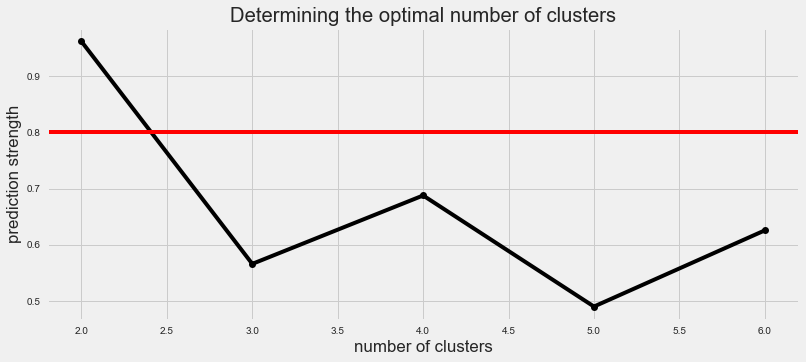

In [20]:
# running the clustering
strengths = []
range_n_clusters = range(2, 7)

for k in tqdm(range_n_clusters):
    model_train = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42).fit(X_test)

    print(f'Train, center`s coordinates for n_clusters {k}:\n{pd.DataFrame(model_train.cluster_centers_).to_string()}\n')
    print(f'Test, center`s coordinates for n_clusters {k}:\n{pd.DataFrame(model_test.cluster_centers_).to_string()}\n\n\n')

    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(range_n_clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

We have got same results, the recommended cluster size is 2, but I prefer 4.

## Summary
The forms of curves become smoother using "kmeans++", which we have got using "Elbow method" and "Average silhouette method".
The "Prediction strength" plot looks the same, but the overall power became lower.
Considering findings, the given results of both approaches (init mode "random" and "kmeans++") seem to be slightly different, but pretty the same.
I found the contradiction in n_cluster=3, between using "Elbow method", "Average silhouette method" and "Prediction strength".
So, probably, in case I would stop my analysis at "Elbow method" and "Average silhouette method", I would prefer n_cluster=2 or 3, more than 4.
But, "Prediction strength" method became "game changer", that leads us to an idea that there are two options n_cluster=2 or 4.

# 4. AgglomerativeClustering
Using the AgglomerativeClustering function of the scikit-learn library, divide the data set into clusters.
Number of clusters choose the same as in the previous method.
Take out coordinates of cluster centers.

## 4.1) Elbow method

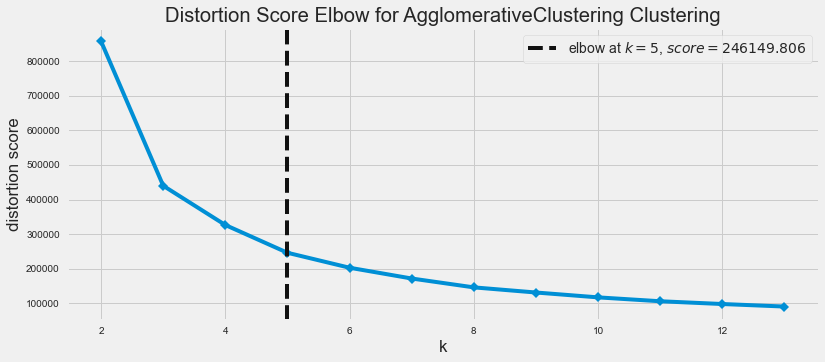

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Instantiate the clustering model and visualizer
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(
    model, k=(2,14), metric='distortion', timings=False
)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In the above plot, the sharpest fall of average distance was spotted at k=5.
The plot is very similar to the previous one (3.1).

## 4.2) Average silhouette method

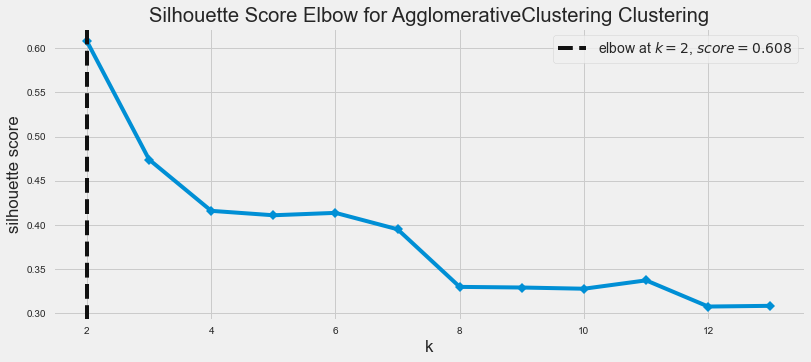

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [22]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(
    model, k=(2,14), metric='silhouette', timings=False
)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

The silhouette plot shows that the n_cluster value of more than 4 is a bad pick.
The next point, at n_cluster=5, trend is broken.
The plot shows that n_cluster=2 is best option, but we can try n_cluster=3 and 4.

## 4.3) Prediction strength method

  0%|          | 0/8 [00:00<?, ?it/s]

Center`s coordinates for n_clusters 2:
         0         1         2         3         4          5          6         7         8         9          10
0  8.088354  0.546646  0.291544  2.875063  0.094367  25.820253  87.369620  0.996947  3.296937  0.677215  10.122869
1  8.403959  0.519774  0.265984  2.395475  0.086507  11.796946  29.367647  0.996641  3.313790  0.657624  10.559201


Center`s coordinates for n_clusters 3:
         0         1         2         3         4          5           6         7         8         9          10
0  8.403959  0.519774  0.265984  2.395475  0.086507  11.796946   29.367647  0.996641  3.313790  0.657624  10.559201
1  8.025625  0.554875  0.310438  3.132500  0.088625  27.243750  113.906250  0.996961  3.259125  0.673250   9.948646
2  8.131064  0.541043  0.278681  2.699787  0.098277  24.851064   69.302128  0.996938  3.322681  0.679915  10.241489


Center`s coordinates for n_clusters 4:
         0         1         2         3         4          5         

[Text(0.5, 1.0, 'Determining the optimal number of clusters'),
 Text(0.5, 0, 'number of clusters'),
 Text(0, 0.5, 'prediction strength')]

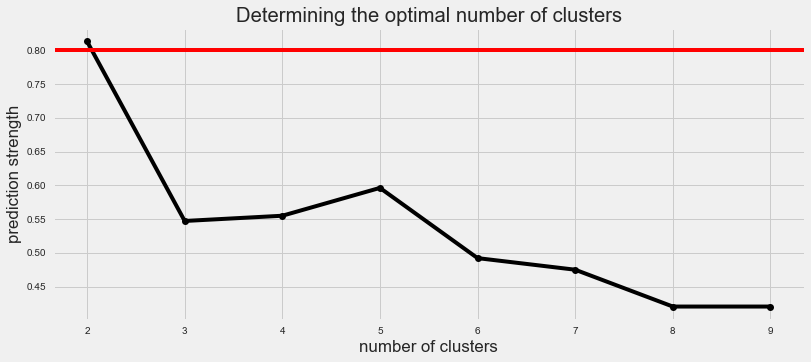

In [23]:
# running the clustering
strengths = []
range_n_clusters = range(2, 10)

for k in tqdm(range_n_clusters):
    model_train = AgglomerativeClustering(n_clusters=k).fit(X_train)
    model_test = AgglomerativeClustering(n_clusters=k).fit(X_test)

    # Computing cluster centers, which are simply the mean of all the rows in that cluster
    # many thanks to https://tushar-osc.medium.com/agglomerativeclustering-with-cluster-centers-e5d409c724d1
    train_cluster_centers = []

    for j_cluster in range(model_train.n_clusters):
        j_cluster_center = X_train[model_train.labels_==j_cluster,:].mean(axis=0)
        train_cluster_centers.append(j_cluster_center)

    print(f'Center`s coordinates for n_clusters {k}:\n{pd.DataFrame(train_cluster_centers).to_string()}\n\n')

    pred_str = get_prediction_strength(k, train_cluster_centers, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(range_n_clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

We can see that the recommended cluster size is 2.
Surprisingly, the next top "prediction strength" value is at n_clusters=5.

## Summary
We got optimal n_clucters=5, using the elbow method.
Then, the average silhouette method showed the best metric at n_clucters=2, but we chose 3-4 range.
The last method showed that the only n_clucters=2 over-performed prediction strength threshold 0.8.
The second-best result was devoted to n_clucters=5.

It is surprising, that at n_cluster=5, "the average silhouette method" plot`s trend is broken,
but the elbow method suggests same value for n_clucters, and "prediction strength" too (in case we want more than 2 clusters).

# 5. K-means vs AgglomerativeClustering comparison

Previously, we have already compared K-means and K-means++ approaches.
Let`s compare K-means++ and AgglomerativeClustering.
The last conclusion at K-means++ section was that the best two values of n_cluster are 2 and 4.
AgglomerativeClustering shows the same top 1 value, but the second is n_cluster=5.

To summarize, the difference between K-means++ and AgglomerativeClustering doesn't seem to be dramatic in terms of optimal n_clusters values.

Meanwhile, we haven't covered at this moment the analysis of differences in centroids.
Another part of clustering analysis is 2D scatter plots using dimensionality reduction technics.
These and other steps could be done within further investigation to compare the clusters themselves more precisely.